(a) Parse and Plot Data

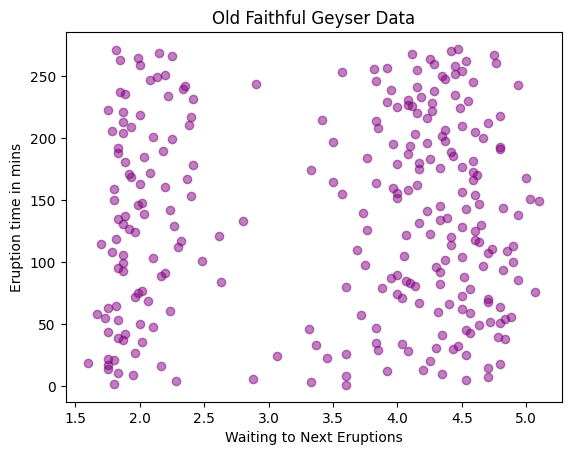

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = np.loadtxt('faithful.dat.txt', skiprows=26)
eruptions = data[:, 0]
waiting_time = data[:, 1]

# Plot on a 2D plane
plt.scatter(waiting_time, eruptions, color='purple', marker='o', alpha=0.5)
plt.xlabel('Waiting to Next Eruptions')
plt.ylabel('Eruption time in mins')
plt.title('Old Faithful Geyser Data')
plt.show()

**(b) Deriving the E-Step**

The posterior probability can be expressed as:

$$
P_{\theta_t}(z = k | x) = \frac{P_{\theta_t}(x | z = k) P_{\theta_t}(z = k)}{\sum_{l=1}^{K} P_{\theta_t}(x | z = l) P_{\theta_t}(z = l)}
$$


The likelihood $P_{\theta_t}(x | z = k)$ can be modeled by a Gaussian distribution $\mathcal{N}(x; \mu_k, \Sigma_k)$, we have the formula like what we saw in the class:

$$
P_{\theta_t}(z = k | x) = \frac{\mathcal{N}(x; \mu_k, \Sigma_k) \cdot \phi_k}{\sum_{l=1}^{K} \mathcal{N}(x; \mu_l, \Sigma_l) \cdot \phi_l}
$$


**(c) Deriving the M-Step**

The optimal parameter updates in the M-step are given by the following formulas:

1. For **Mean** $\mu_k^* $:

   $$
   \mu_k^* = \frac{\sum_{i=1}^n P(z = k | x^{(i)}) x^{(i)}}{n_k}
   $$

2. For **Covariance** $\Sigma_k^* $:

   $$
   \Sigma_k^* = \frac{\sum_{i=1}^n P(z = k | x^{(i)}) (x^{(i)} - \mu_k^*)(x^{(i)} - \mu_k^*)^T}{n_k}
   $$

where $ n_k = \sum_{i=1}^n P(z = k | x^{(i)}) $.

3. Lastly $\phi_k = \frac{n_k}{n}$

**(d) Implement EM Algorithm**

(i) ImplementtheEMalgorithmfromscratch(e.g.,inPythonandnumpy).

In [14]:
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Repeat EM algorithm with meanltiple initializations
best_mix_coe1, best_mix_coe2 = None, None
best_mean1, best_mean2 = None, None
best_co_var1, best_co_var2 = None, None
best_log_likelihood = -np.inf #track result
best_convergence_iteration = None  

for init in range(10):  # Try 10 initializations

    mean1 = np.random.rand(2)
    mean2 = np.random.rand(2)
    co_var1 = np.diag([1.0, 1.0])
    co_var2 = np.diag([1.0, 1.0])
    mix_coe1, mix_coe2 = 0.5, 0.5

    # EM Algorithm
    for iteration in range(max_iters):
        # E-Step
        resp = []
        for x in data:
            p_x_given_z1 = gaussian_pdf(x, mean1, co_var1) * mix_coe1
            p_x_given_z2 = gaussian_pdf(x, mean2, co_var2) * mix_coe2
            total = max(p_x_given_z1 + p_x_given_z2, 1e-10)
            resp_z1 = p_x_given_z1 / total
            resp_z2 = p_x_given_z2 / total
            resp.append([resp_z1, resp_z2])

        resp = np.array(resp)

        # M-Step
        n_k1 = np.sum(resp[:, 0])
        n_k2 = np.sum(resp[:, 1])
        
        mean1_new = np.sum(resp[:, 0].reshape(-1, 1) * data, axis=0) / n_k1
        mean2_new = np.sum(resp[:, 1].reshape(-1, 1) * data, axis=0) / n_k2
        
        co_var1_new = (resp[:, 0].reshape(-1, 1) * (data - mean1_new)).T @ (data - mean1_new) / n_k1
        co_var1_new += np.eye(2) * 1e-6 

        co_var2_new = (resp[:, 1].reshape(-1, 1) * (data - mean2_new)).T @ (data - mean2_new) / n_k2
        co_var2_new += np.eye(2) * 1e-6

        mix_coe1_new = n_k1 / len(data)
        mix_coe2_new = n_k2 / len(data)

        # Termination rule: Check for convergence
        if np.linalg.norm(mean1_new - mean1) < tolerance and np.linalg.norm(mean2_new - mean2) < tolerance:
            print(f"Initialization {init + 1}: Converged at iteration {iteration}")
            break

        # Update 
        mean1, mean2 = mean1_new, mean2_new
        co_var1, co_var2 = co_var1_new, co_var2_new
        mix_coe1, mix_coe2 = mix_coe1_new, mix_coe2_new
        
    log_likelihood = np.sum(np.log(resp[:, 0] * mix_coe1 + resp[:, 1] * mix_coe2))
    if log_likelihood > best_log_likelihood:
        best_log_likelihood = log_likelihood
        best_mix_coe1, best_mix_coe2 = mix_coe1, mix_coe2
        best_mean1, best_mean2 = mean1, mean2
        best_co_var1, best_co_var2 = co_var1, co_var2
        best_convergence_iteration = iteration 


print("Best means:", best_mean1, best_mean2)
print("Best covariances:\n", best_co_var1, "\n", best_co_var2)
print("Best mixing coefficients:", best_mix_coe1, best_mix_coe2)
print("Best convergence at iteration:", best_convergence_iteration)

Initialization 1: Converged at iteration 33
Initialization 2: Converged at iteration 28
Initialization 3: Converged at iteration 35
Initialization 4: Converged at iteration 29
Initialization 5: Converged at iteration 31
Initialization 6: Converged at iteration 25
Initialization 8: Converged at iteration 36
Initialization 9: Converged at iteration 30
Initialization 10: Converged at iteration 25
Best means: [0.00911168 0.68763094] [-0.01711163 -1.29136255]
Best covariances:
 [[1.00135497 0.01533695]
 [0.01533695 0.14946885]] 
 [[0.99700953 0.05240579]
 [0.05240579 0.04169195]]
Best mixing coefficients: 0.6525350156123492 0.3474649843876509
Best convergence at iteration: 36


In [16]:
# # wanted to double check the results by visualizing the data and the fitted Gaussians

# import matplotlib.pyplot as plt
# from matplotlib.patches import Ellipse

# def plot_gaussian(mean, cov, ax, color):
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
#     order = eigenvalues.argsort()[::-1]
#     eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
#     angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
#     width, height = 2 * np.sqrt(eigenvalues)
#     ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=color, fc='None', lw=2)
#     ax.add_patch(ellipse)

# plt.scatter(data[:, 0], data[:, 1], s=10, label='Data')

# fig, ax = plt.subplots()
# plot_gaussian(best_mean1, best_co_var1, ax, 'red')
# plot_gaussian(best_mean2, best_co_var2, ax, 'blue')

# # Plot means
# plt.scatter(best_mean1[0], best_mean1[1], c='red', s=100, marker='x', label='Mean 1')
# plt.scatter(best_mean2[0], best_mean2[1], c='blue', s=100, marker='x', label='Mean 2')

# plt.legend()
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()

**(ii) Termination Rule**
Terminate when convergence is reached, typically when the model parameters stop changing significantly. Here in the code I check each iteration the change in means in two clusters separately, since the means primarily determine cluster positions. By checking if the change has become minimal it can monitor the convergence.

**(iii)Plot the trajectories**

Same code as in (i) but added the lines with comment #For trajectory plotting to store the mean coodinate at each iteration.

Initialization 1: Converged at iteration 24
Initialization 2: Converged at iteration 28
Initialization 3: Converged at iteration 23
Initialization 4: Converged at iteration 26
Initialization 5: Converged at iteration 26
Initialization 6: Converged at iteration 37
Initialization 7: Converged at iteration 23
Initialization 8: Converged at iteration 26
Initialization 9: Converged at iteration 27
Initialization 10: Converged at iteration 37


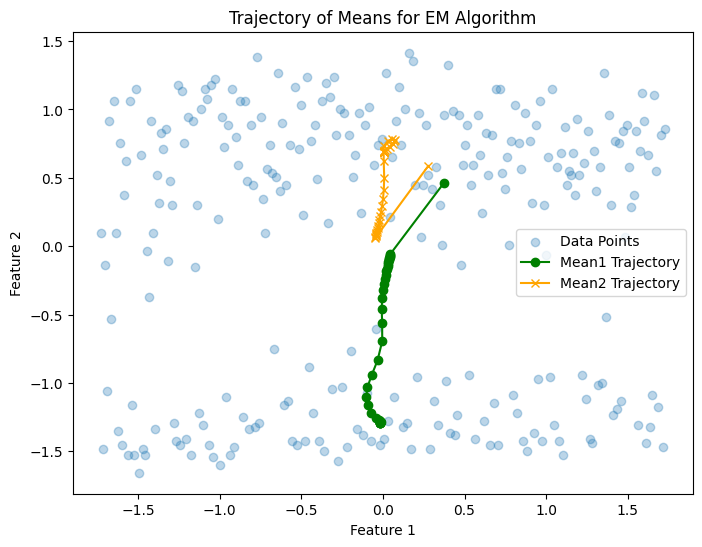

Best means: [-0.01710827 -1.29135602] [0.00911002 0.68763735]
Best covariances:
 [[0.99700776 0.05240808]
 [0.05240808 0.04169618]] 
 [[1.00135603 0.01533892]
 [0.01533892 0.14946133]]
Best mixing coefficients: 0.3474682442162626 0.6525317557837373
Best convergence at iteration: 26


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Repeat EM algorithm with multiple initializations
best_mix_coe1, best_mix_coe2 = None, None
best_mean1, best_mean2 = None, None
best_co_var1, best_co_var2 = None, None
best_log_likelihood = -np.inf  
best_convergence_iteration = None  

# For trajectory plotting
mean1_trajectory = []
mean2_trajectory = []

for init in range(10):  
    mean1 = np.random.rand(2)
    mean2 = np.random.rand(2)
    co_var1 = np.diag([1.0, 1.0])
    co_var2 = np.diag([1.0, 1.0])
    mix_coe1, mix_coe2 = 0.5, 0.5

    # For trajectory plotting
    mean1_trajectory.clear()
    mean2_trajectory.clear()
    
    # EM Algorithm
    for iteration in range(max_iters):
        
        # For trajectory plotting
        mean1_trajectory.append(mean1.copy())
        mean2_trajectory.append(mean2.copy())
        
        # E-Step
        resp = []
        for x in data:
            p_x_given_z1 = gaussian_pdf(x, mean1, co_var1) * mix_coe1
            p_x_given_z2 = gaussian_pdf(x, mean2, co_var2) * mix_coe2
            total = max(p_x_given_z1 + p_x_given_z2, 1e-10)
            resp_z1 = p_x_given_z1 / total
            resp_z2 = p_x_given_z2 / total
            resp.append([resp_z1, resp_z2])

        resp = np.array(resp)

        # M-Step
        n_k1 = np.sum(resp[:, 0])
        n_k2 = np.sum(resp[:, 1])
        
        mean1_new = np.sum(resp[:, 0].reshape(-1, 1) * data, axis=0) / n_k1
        mean2_new = np.sum(resp[:, 1].reshape(-1, 1) * data, axis=0) / n_k2
        
        co_var1_new = (resp[:, 0].reshape(-1, 1) * (data - mean1_new)).T @ (data - mean1_new) / n_k1
        co_var1_new += np.eye(2) * 1e-6 

        co_var2_new = (resp[:, 1].reshape(-1, 1) * (data - mean2_new)).T @ (data - mean2_new) / n_k2
        co_var2_new += np.eye(2) * 1e-6

        mix_coe1_new = n_k1 / len(data)
        mix_coe2_new = n_k2 / len(data)

        # Termination rule: Check for convergence
        if np.linalg.norm(mean1_new - mean1) < tolerance and np.linalg.norm(mean2_new - mean2) < tolerance:
            print(f"Initialization {init + 1}: Converged at iteration {iteration}")
            break

        # Update 
        mean1, mean2 = mean1_new, mean2_new
        co_var1, co_var2 = co_var1_new, co_var2_new
        mix_coe1, mix_coe2 = mix_coe1_new, mix_coe2_new
        
    log_likelihood = np.sum(np.log(resp[:, 0] * mix_coe1 + resp[:, 1] * mix_coe2))
    if log_likelihood > best_log_likelihood:
        best_log_likelihood = log_likelihood
        best_mix_coe1, best_mix_coe2 = mix_coe1, mix_coe2
        best_mean1, best_mean2 = mean1, mean2
        best_co_var1, best_co_var2 = co_var1, co_var2
        best_convergence_iteration = iteration 

# For trajectory plotting
mean1_trajectory = np.array(mean1_trajectory)
mean2_trajectory = np.array(mean2_trajectory)

# Plot the trajectories of the means
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.3, label='Data Points')
plt.plot(mean1_trajectory[:, 0], mean1_trajectory[:, 1], marker='o', color='green', label='Mean1 Trajectory')
plt.plot(mean2_trajectory[:, 0], mean2_trajectory[:, 1], marker='x', color='orange', label='Mean2 Trajectory')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Trajectory of Means for EM Algorithm')
plt.legend()
plt.show()

# Output the best results
print("Best means:", best_mean1, best_mean2)
print("Best covariances:\n", best_co_var1, "\n", best_co_var2)
print("Best mixing coefficients:", best_mix_coe1, best_mix_coe2)
print("Best convergence at iteration:", best_convergence_iteration)

**(e) K -means**

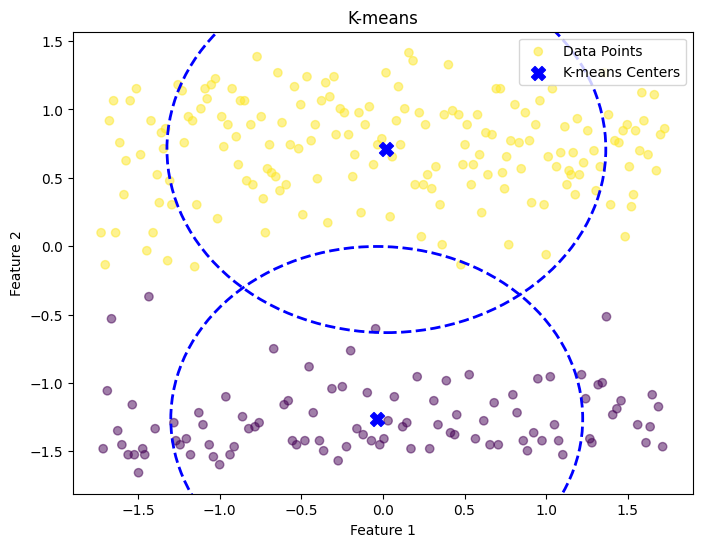

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


kmeans = KMeans(n_clusters=2, random_state=0)
kmeans_labels = kmeans.fit_predict(data)
kmeans_centers = kmeans.cluster_centers_

std_devs = []
for i in range(2):
    cluster_points = data[kmeans_labels == i]
    std_dev = np.std(cluster_points, axis=0)
    std_devs.append(std_dev)

# Plot K-means results
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='viridis', marker='o', alpha=0.5, label='Data Points')
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='blue', marker='X', s=100, label='K-means Centers')

# contour 
for i, center in enumerate(kmeans_centers):
    circle = plt.Circle(center, 2 * np.mean(std_devs[i]), color='blue', fill=False, linestyle='--', linewidth=2)
    plt.gca().add_artist(circle)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means')
plt.legend()
plt.show()

K-means Cluster Centers (Means):
Center 1: [-0.03768743 -1.26322023]
Center 2: [0.02122626 0.71146886]


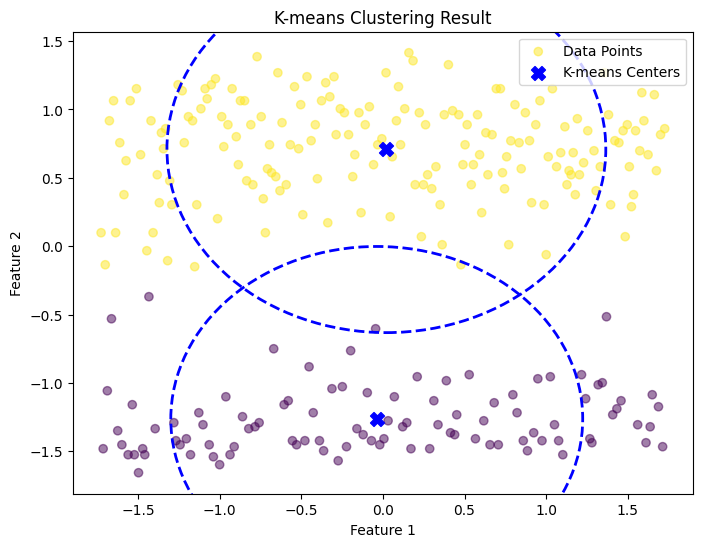

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Run K-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans_labels = kmeans.fit_predict(data)
kmeans_centers = kmeans.cluster_centers_

# Print coordinates of the K-means cluster centers
print("K-means Cluster Centers (Means):")
for i, center in enumerate(kmeans_centers):
    print(f"Center {i + 1}: {center}")

# Calculate standard deviations for contour circles
std_devs = []
for i in range(2):
    cluster_points = data[kmeans_labels == i]
    std_dev = np.std(cluster_points, axis=0)
    std_devs.append(std_dev)

# Plot K-means results
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='viridis', marker='o', alpha=0.5, label='Data Points')
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='blue', marker='X', s=100, label='K-means Centers')

# Draw contour circles around each K-means center
for i, center in enumerate(kmeans_centers):
    circle = plt.Circle(center, 2 * np.mean(std_devs[i]), color='blue', fill=False, linestyle='--', linewidth=2)
    plt.gca().add_artist(circle)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering Result')
plt.legend()
plt.show()

The result changed but not that much. I am assuming that the two clusters don't overlap with each other that much originally. But still, K means diretly optimizes the distances between points and centroids, and assign each point to the nearest cluster center hard (vs EM is probabilistic). These might cause the shift in the results. 